# Build models using raw element data
The error analysis reminds me to check the model's performance using raw elemental data without rolling trick, which I tried in the pilot stage. Sadly, its performance (Colab/WASA/ML_rawdata_workflow.ipynb) is even better than the best performance we got now. Since it is a pilot approach, the elements, scoring metric and spliting are different to the workflow now. Some analytes use by that time are not sensible to use due to some cheating issue, such as sample_surface. we need to make them consistent for proper comparison. The models are built using the training set in the training-dev-test subsets.

Later we produce Eveluation and further visulizatoin of the redo and optimized models (lr, SVC, RF).

In [1]:
import numpy as np 
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
#mpl.rcParams['xtick.labelsize'] = 8
#mpl.rcParams["image.cmap"] = 'gray'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

%matplotlib inline

# Check the raw element data

In [2]:
data_df = pd.read_csv('data/XRF_ML.csv')
data_df.head()

,composite_id,composite_depth_mm,core_id,core_section,section_depth_mm,facies_merge_2,Ba,Br,Ca,Cl,Fe,K,Rb,S,Si,Sr,Ti,Zr
0,N10_00003,3,N10,N10-5,3.0,0,149,0,6327,674,2384,2693,124,57,5522,158,1408,1549
1,N10_00005,5,N10,N10-5,5.0,0,125,8,7200,643,2171,2795,170,40,5153,205,1025,1369
2,N10_00007,7,N10,N10-5,7.0,0,102,11,5992,596,1879,2673,131,7,5208,207,1225,1199
3,N10_00009,9,N10,N10-5,9.0,0,127,0,10409,598,2095,2751,98,13,5045,226,1758,968
4,N10_00011,11,N10,N10-5,11.0,0,144,30,13011,560,1997,2699,80,25,5082,252,1756,1334


In [3]:
data_df.shape

(158909, 18)

This dataset is without clr and rolling.

# ML Gridsearch

## LR
The gridsearch is executed by grid_raw_lr.py and submit_raw.sh using cluster (no dask involved). The number of searched models is 2 (with or without PCA) * 10 (lr__C) * 5 (cv) = 100. It takes 1 minutes to finish the gridsearch. The best model is with PCA and stored as raw_lr_model_20210518.joblib. The job log is slurm-52882.txt. 

In [38]:
lr_df = pd.read_csv('results/raw_lr_grid_20210519.csv', index_col=0)

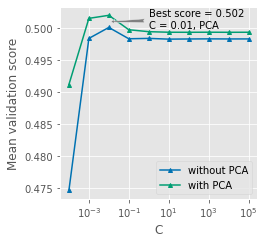

In [39]:
fig = plt.figure(figsize = (3.54, 3.54))

data_df = lr_df.copy()
x_col = 'param_lr__C'
max_index = np.argmax(data_df.mean_test_score)
plt.xscale('log')
#plt.ylim(0.545, 0.595)
#plt.yticks(np.linspace(0.4, 0.59, 4))

for label, mask in zip(['without PCA', 'with PCA'], [data_df.param_pca != 'PCA(whiten=True)', data_df.param_pca == 'PCA(whiten=True)']):
    xx = data_df.loc[mask, x_col].values.astype(float)
    yy = data_df.loc[mask, 'mean_test_score'].values.astype(float)
    plt.plot(xx, yy, marker = '^', ms = 4, label = label)

plt.ylabel('Mean validation score')
plt.xlabel('C')
plt.legend()

plt.annotate(text = 'Best score = {:.3f}\nC = {}, {}'.format(data_df.mean_test_score[max_index], data_df.loc[max_index, x_col], data_df.param_pca[max_index][:3]),
             xy = (data_df.loc[max_index, x_col], data_df.mean_test_score[max_index]-.001),
             xytext = (1, 0.5), arrowprops=dict(facecolor='gray', arrowstyle = 'fancy')
            )
#fig.subplots_adjust(wspace = 0.05)
fig.savefig('results/raw_lr_grid_combined_{}.png'.format(date))

The performance difference between models with and without PCA is not clear.

## RBF SVM
The gridsearch is executed by grid_svc.py and submit_svc.sh using cluster (no dask involved). The number of searched models is 2 (with or without PCA) * 9 (svc__gamma) * 7 (svc__C) * 5 (cv) = 630. @@@It takes 11 hours to finish the gridsearch. The best model is without PCA and stored as roll_svc_model_20201121.joblib. The job log is slurm-20834.txt. 

In [2]:
svc_df = pd.read_csv('results/raw_svc_grid_20210519.csv', index_col = 0)
len(svc_df)

96

In [3]:
np.max(svc_df.mean_test_score.astype(float))

0.5364655616198609

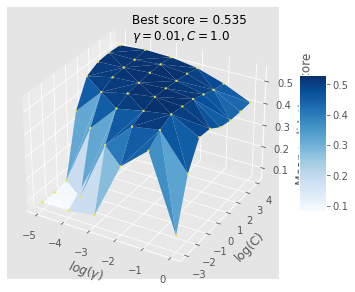

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize = (7,5))
ax = plt.gca(projection='3d')
xx = svc_df.loc[svc_df.param_pca != 'PCA(whiten=True)', 'param_svc__gamma'].values.astype(float)
yy = svc_df.loc[svc_df.param_pca != 'PCA(whiten=True)', 'param_svc__C'].values.astype(float)
zz = svc_df.loc[svc_df.param_pca != 'PCA(whiten=True)', 'mean_test_score'].values.astype(float)
max_index = np.argmax(zz)

surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap = cm.Blues, linewidth = 0.1)
ax.scatter(np.log10(xx), np.log10(yy), zz, c = 'C4', s = 3, alpha = 1)

# mark the best score
text = 'Best score = {:.3f}\n$\gamma = {}, C = {}$'.format(zz[max_index], xx[max_index], yy[max_index])
ax.text(-2, -2, .85, text, fontsize = 12)
#ax.quiver(np.log10(xx[max_index]), np.log10(yy[max_index]), zz[max_index], 
#          .3, .3, .3, color='gray', alpha=.6)

ax.set_xlabel('$log(\gamma)$')
ax.set_ylabel('log(C)')
ax.set_zlabel('Mean validation score')
fig.colorbar(surf, shrink = 0.5, aspect = 5)
fig.savefig('results/raw_svc_grid_20201121.png')

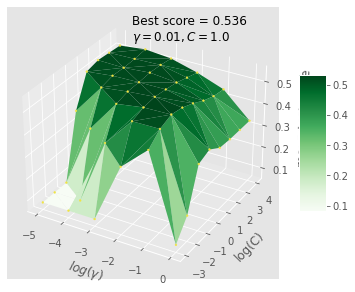

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize = (7,5))
ax = plt.gca(projection='3d')
xx = svc_df.loc[svc_df.param_pca == 'PCA(whiten=True)', 'param_svc__gamma'].values.astype(float)
yy = svc_df.loc[svc_df.param_pca == 'PCA(whiten=True)', 'param_svc__C'].values.astype(float)
zz = svc_df.loc[svc_df.param_pca == 'PCA(whiten=True)', 'mean_test_score'].values.astype(float)
max_index = np.argmax(zz)

surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap = cm.Greens, linewidth = 0.1)
ax.scatter(np.log10(xx), np.log10(yy), zz, c = 'C4', s = 3, alpha = 1)
# mark the best score
text = 'Best score = {:.3f}\n$\gamma = {}, C = {}$'.format(zz[max_index], xx[max_index], yy[max_index])
ax.text(-2, -2, .85,text, fontsize = 12)
#ax.quiver(np.log10(xx[max_index]), np.log10(yy[max_index]), zz[max_index], 
#          .3, .3, .3, arrow_length_ratio=0.1, color='gray', alpha=.6)

ax.set_xlabel('$log(\gamma)$')
ax.set_ylabel('log(C)')
ax.set_zlabel('mean test score')
fig.colorbar(surf, shrink = 0.5, aspect = 5)
fig.savefig('results/raw_pca+svc_grid_20201121.png')

## RandomForest (RF)
The gridsearch is implemented by grid_rf.py and submit_rf.sh using cluster (no dask involved). Three amounts of n_estimators (100 (default), 1000, 5000) are searched. RF really comsumes a lot memory surign computation. The number of searched models is 2 (with or without PCA) * 3 (rf__n_estimators) * 3 (rf__max_depth) * 5 (cv) = 90. It takes 1.5 hours to finish the gridsearch. The best model is without PCA and stored as raw_rf_model_20210518.joblib (1.1 GB). The job log is slurm-52892.txt.

Usually, n_estimators is the more the better generalization because it provides more regularization strength. However, the more n_estimators means more computation and memery loading. Although the 5000 n_estimators seems not reach the peak of rising trend and we might find some ways to solve the memory limit of cluster, I don't think it's sensible to persuit the higher n_estimators because the model's size will be too big for later applications.

In [2]:
rf_df = pd.read_csv('results/raw_rf_grid_20210519.csv', index_col = 0)

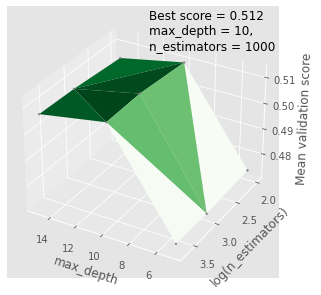

In [32]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

row_range = range(9) # with PCA
fig = plt.figure(figsize = (7,5))
ax = plt.gca(projection='3d')
xx = rf_df.param_rf__max_depth.values.astype(int)[row_range]
yy = rf_df.param_rf__n_estimators.values.astype(int)[row_range]
zz = rf_df.mean_test_score.values.astype(float)[row_range]
max_index = np.argmax(zz)

surf = ax.plot_trisurf(xx, np.log10(yy), zz, cmap = cm.Greens, linewidth = 0.1)
ax.scatter(xx, np.log10(yy), zz, c = 'grey', s = 3, alpha = 1)

# mark the best score
text = 'Best score = {:.3f}\nmax_depth = {},\nn_estimators = {}'.format(zz[max_index], xx[max_index], yy[max_index])
ax.text(12, 2.2, .515,text, fontsize = 12)
#ax.quiver(np.log10(xx[max_index]), np.log10(yy[max_index]), zz[max_index], 
#          .3, .3, .3, color='gray', alpha=.6)

ax.set_zticks(np.linspace(0.47, 0.51, 5))
ax.set_yticks(np.linspace(2, 3.5, 4))
ax.set_xlabel('max_depth')
ax.set_ylabel('log(n_estimators)')
ax.set_zlabel('Mean validation score')
#fig.colorbar(surf, shrink = 0.5, aspect = 5)

# rotate the axes
ax.view_init(30, 120)
fig.savefig('results/raw_pca+rf_grid_{}.png'.format(date))

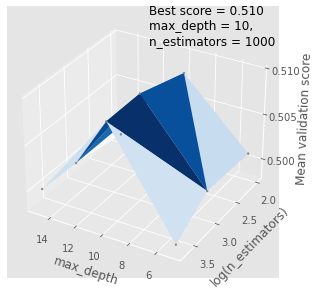

In [31]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

row_range = range(9,18) # without PCA
fig = plt.figure(figsize = (7,5))
ax = plt.gca(projection='3d')
xx = rf_df.param_rf__max_depth.values.astype(int)[row_range]
yy = rf_df.param_rf__n_estimators.values.astype(int)[row_range]
zz = rf_df.mean_test_score.values.astype(float)[row_range]
max_index = np.argmax(zz)

surf = ax.plot_trisurf(xx, np.log10(yy), zz, cmap = cm.Blues, linewidth = 0.1)
ax.scatter(xx, np.log10(yy), zz, c = 'grey', s = 3, alpha = 1)

# mark the best score
text = 'Best score = {:.3f}\nmax_depth = {},\nn_estimators = {}'.format(zz[max_index], xx[max_index], yy[max_index])
ax.text(12, 2.2, .511,text, fontsize = 12)
#ax.quiver(np.log10(xx[max_index]), np.log10(yy[max_index]), zz[max_index], 
#          .3, .3, .3, color='gray', alpha=.6)

ax.set_zticks(np.linspace(0.50, 0.51, 3))
ax.set_yticks(np.linspace(2, 3.5, 4))
ax.set_xlabel('max_depth')
ax.set_ylabel('log(n_estimators)')
ax.set_zlabel('Mean validation score')
#fig.colorbar(surf, shrink = 0.5, aspect = 5)

# rotate the axes
ax.view_init(30, 120)

fig.savefig('results/raw_rf_grid_{}.png'.format(date))

# Eveluation on dev set

In [16]:
from split import *
data_df = pd.read_csv('data/XRF_ML_c.csv')
X = data_df.iloc[:, 1:-2].values
y = data_df['facies_merge_2'].values
groups = data_df['core_section'].values

train_idx, test_idx = my_train_test_split(y, groups)
trainn_idx, dev_idx = my_group_stratify_shuffle(X[train_idx],y[train_idx], groups[train_idx])

In [33]:
from joblib import load
lr = load('models/raw_lr_model_20210519.joblib')
svc = load('models/raw_svc_model_20210519.joblib')
rf = load('models/raw_rf_model_20210519.joblib')

In [34]:
X_dev = X[train_idx[dev_idx]]
y_dev = y[train_idx[dev_idx]]

In [35]:
y_df = pd.DataFrame(y_dev, columns=['y'])
for col, model in zip(['y_lr', 'y_svc', 'y_rf'], [lr, svc, rf]):
    y_df[col] = model.predict(X_dev)

In [52]:
y_df['core_section'] = groups[train_idx[dev_idx]]
y_df

,y,y_lr,y_svc,y_rf,id,core_section
0,0,0,0,6,0,N11-2
1,0,0,0,0,1,N11-2
2,0,11,11,11,2,N11-2
3,0,0,0,2,3,N11-2
4,0,0,0,2,4,N11-2
...,...,...,...,...,...,...
22371,8,7,7,7,22371,W3-1
22372,8,8,7,7,22372,W3-1
22373,8,7,7,7,22373,W3-1
22374,8,9,7,7,22374,W3-1


## Scores

In [37]:
from sklearn.metrics import balanced_accuracy_score as score
for col in ['y_lr', 'y_svc', 'y_rf']:
    print('Balanced score of {}: {:.2f}'.format(col, score(y_true=y_df.y, y_pred=y_df[col])))

Balanced score of y_lr: 0.57
Balanced score of y_svc: 0.62
Balanced score of y_rf: 0.59


## Matrices

In [38]:
facies = ['shoreface', 'channel', 'beach-foreshore', 'sand flat', 'mud flat',
       'lagoon', 'peat', 'soil', 'eolian/fluvial (W)',
       'shallow marine', 'moraine', 'eolian/fluvial']

Facies = []
for fa in facies:
    Facies.append(fa.capitalize())

Facies

['Shoreface',
 'Channel',
 'Beach-foreshore',
 'Sand flat',
 'Mud flat',
 'Lagoon',
 'Peat',
 'Soil',
 'Eolian/fluvial (w)',
 'Shallow marine',
 'Moraine',
 'Eolian/fluvial']

In [48]:
def plot_recall(data_df, y_preds, Facies, split):
    """
    data_df is the dataframe having info and labels.
    y_preds is a list of the column names of labels you want to plot.
    Faceis is a list of facies names.
    split is the name of the dataset, which used for filename (train or test)
    """
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import balanced_accuracy_score as score

    for col in y_preds:
        # make confusion matrix between prediction and actual labels
        confusion = confusion_matrix(data_df.y, data_df[col])
        model_name = col[2:]
        con_df = pd.DataFrame(confusion, index = Facies, columns = Facies)
        #con_df.to_csv('results/roll_confusion_{}_{}.csv'.format(model_name, date))

        # normalize the counts ineach row and present in percent
        x = np.copy(confusion).astype(float)
        x /= x.sum(axis = 1, keepdims = True)
        con_per = pd.DataFrame((x*100).astype(int), index = Facies, columns = Facies)
        #con_per.to_csv('results/roll_recall_%_{}_{}.csv'.format(model_name, date))

        # Plot the matrix
        fig, ax = plt.subplots(1, 1, figsize = (7, 5))
        sns.heatmap(con_per, annot = con_per.astype(str), ax = ax, cmap = 'GnBu', square = True, vmin=0, vmax=100,
                    xticklabels = con_per.index, yticklabels = con_per.columns, fmt = 's', 
                    annot_kws={'size': 7}, cbar_kws = {'label' : 'Data percentage in each row'}
                   )

        ax.set_xlabel('Prediction (accuracy: {:.2f})'.format(score(y_true=data_df.y, y_pred=data_df[col])), size = 14)
        ax.set_ylabel('Actual facies', size = 14)
        fig.savefig('results/raw_{}_recall_%_{}_{}.png'.format(split, model_name, date))

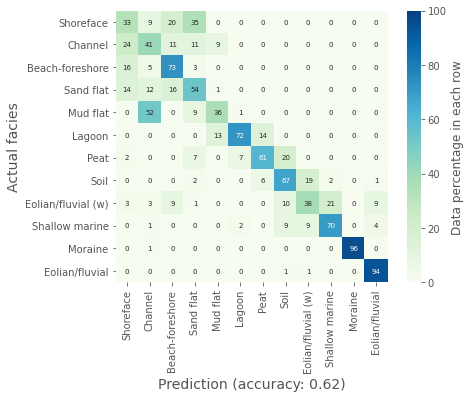

In [49]:
plot_recall(y_df, ['y_svc'], Facies, 'dev')

In [50]:
def detect_conjuction(data_df, y_preds, Facies, split):
    """
    data_df is the dataframe having info and labels.
    y_preds is a list of the column names of labels you want to plot.
    Faceis is a list of facies names.
    split is the name of the dataset, which used for filename (train or test).
    """
    
    data_df['id'] = range(len(data_df))
    mat_dict = {}


    for y_pred in y_preds:
        y_mean = []
        composite_id = []
        model_name = y_pred[2:] if len(y_pred)>1 else 'description'
        
        for section in np.unique(data_df.core_section):
            y_mean = np.hstack((y_mean, data_df.loc[data_df.core_section == section, y_pred].rolling(window = 2).mean()))
            composite_id = np.hstack((composite_id, data_df[data_df.core_section == section].index))

        # merge the rolling with the original label
        # this will lost the first data poit in each section, but it doesn't mater
        # because the boundary shouldn't be at the begining of each section
        tmp_df = pd.concat([data_df, pd.DataFrame({'y_mean': y_mean}, index = composite_id).dropna()], join = 'inner', axis = 1)

        # if y_pred is not same as y_mean, it means there is a boundary (facies change) between this and above depth
        bd_df = tmp_df[tmp_df[y_pred] != tmp_df.y_mean].copy()
        bd_df['ab_id'] = bd_df.id - 1
        if len(model_name) > 3:
            print('There are {} boundaries in description.'.format(len(bd_df)))
        else:
            print('There are {} boundaries in the optimized {} model\'s predictions.'.format(len(bd_df), model_name))

        # build matrix of boundaries
        bd_mat = np.zeros(shape = (12, 12), dtype = int)

        for row in bd_df.iterrows():
            tmp = np.zeros(shape = (12, 12), dtype = int)
            tmp[data_df[y_pred][int(row[1].ab_id)], data_df[y_pred][int(row[1].id)]] = 1
            bd_mat += tmp
            
        mat_dict[y_pred] = bd_mat
        
        # plot
        fig, ax = plt.subplots(1, 1, figsize = (7, 5))
        sns.heatmap(bd_mat, annot = bd_mat.astype(str), ax = ax, cmap = 'Greens', square = True, #vmin=0, vmax=130,
                    xticklabels = Facies, yticklabels = Facies, fmt = 's', 
                    annot_kws={'size': 7}, cbar_kws = {'label' : 'Counts (total: {})'.format(len(bd_df))}
                   )
        ax.set_xlabel('Below facies', size = 16)
        ax.set_ylabel('Above facies', size = 16)
        fig.savefig('results/raw_{}_conjunction_matrix_{}_{}.png'.format(split, model_name, date))
    
    return mat_dict

There are 7567 boundaries in the optimized lr model's predictions.
There are 6635 boundaries in the optimized svc model's predictions.
There are 6671 boundaries in the optimized rf model's predictions.


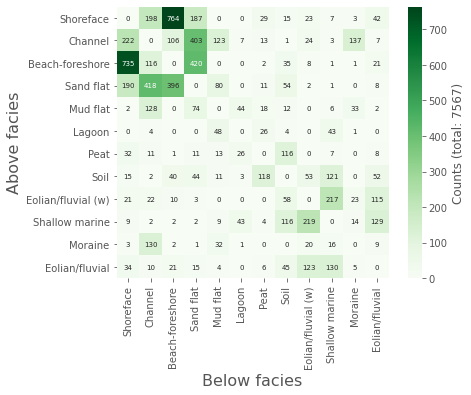

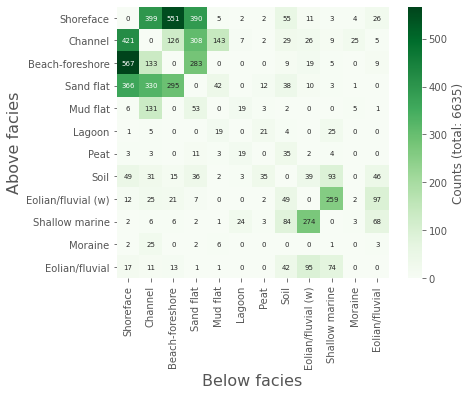

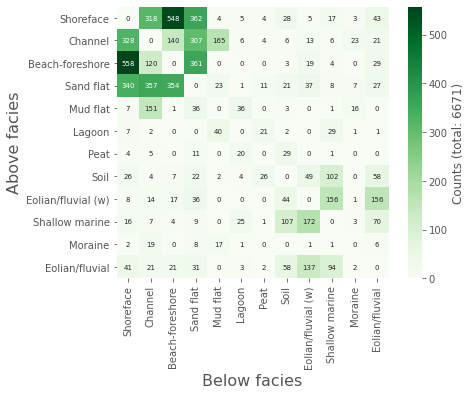

In [53]:
mat_dict = detect_conjuction(y_df,  ['y_lr', 'y_svc', 'y_rf'], Facies, 'dev')

## Comparision
The best model using the rolling data (SVC), which is chosen as the major workflow, gives 0.63 balanced score on dev set accorind to ML_element_08 and also 0.63 CV score (this CV use training 
and dev sets because I don't have the idea of dev set at that time) according to ML_element_05.ipynb. The best model using the raw data (also SVC) gives 0.62 balanced score on dev set (this notebook) and 0.54 CV score (this notebook) based on only the training set. Although the CV was utilized on the different datasets: the model using raw data utilizes CV only on the training set while the model using rolling data utilizes on the dataset combining training and dev sets, the CV score shouldn't be affected significantly. It's because that the distribution of these two datasets are the same and the data amount is close. I prefer to use CV score instead of the score on dev set to evaluate model's error since the CV score is the averaged scores from 5 iterations of data splitting while the score on dev set only has once. However, since it's not feasible to also apply this 5 iteration on error analysis, including the matrices, I choose to use these results from dev set as a reasonable compromizing. From this stage, the SVC modle using the rolling data significantly reduces the error (1 - score) and boundaries comparing to those of the model using the raw data (0.46 -> 0.37, 6635 -> 1032). This means the rolling trick does help in improving score and the issue of fragmented prediction, but still can be better.